<strong>  Times arrivals of seismic waves in El Salvador </strong>

El Salvador is a country that is located in Central America. The main reasons of the high seismicity in El Salvador is the subduction zone, although local faults also can generate seismicity.

This project tries to show the time arrivals of seismic wave to the salvadoran seismic network, using ar_pick function from obspy to pick P phase and S phase. The process is done with 4 events (They're shown in the next figure). This events were chosen due to the high magnitude and the available information. In El Salvador had ocurred higher magnitude earthquakes, but pitifully there isn't available seismic records in obspy.

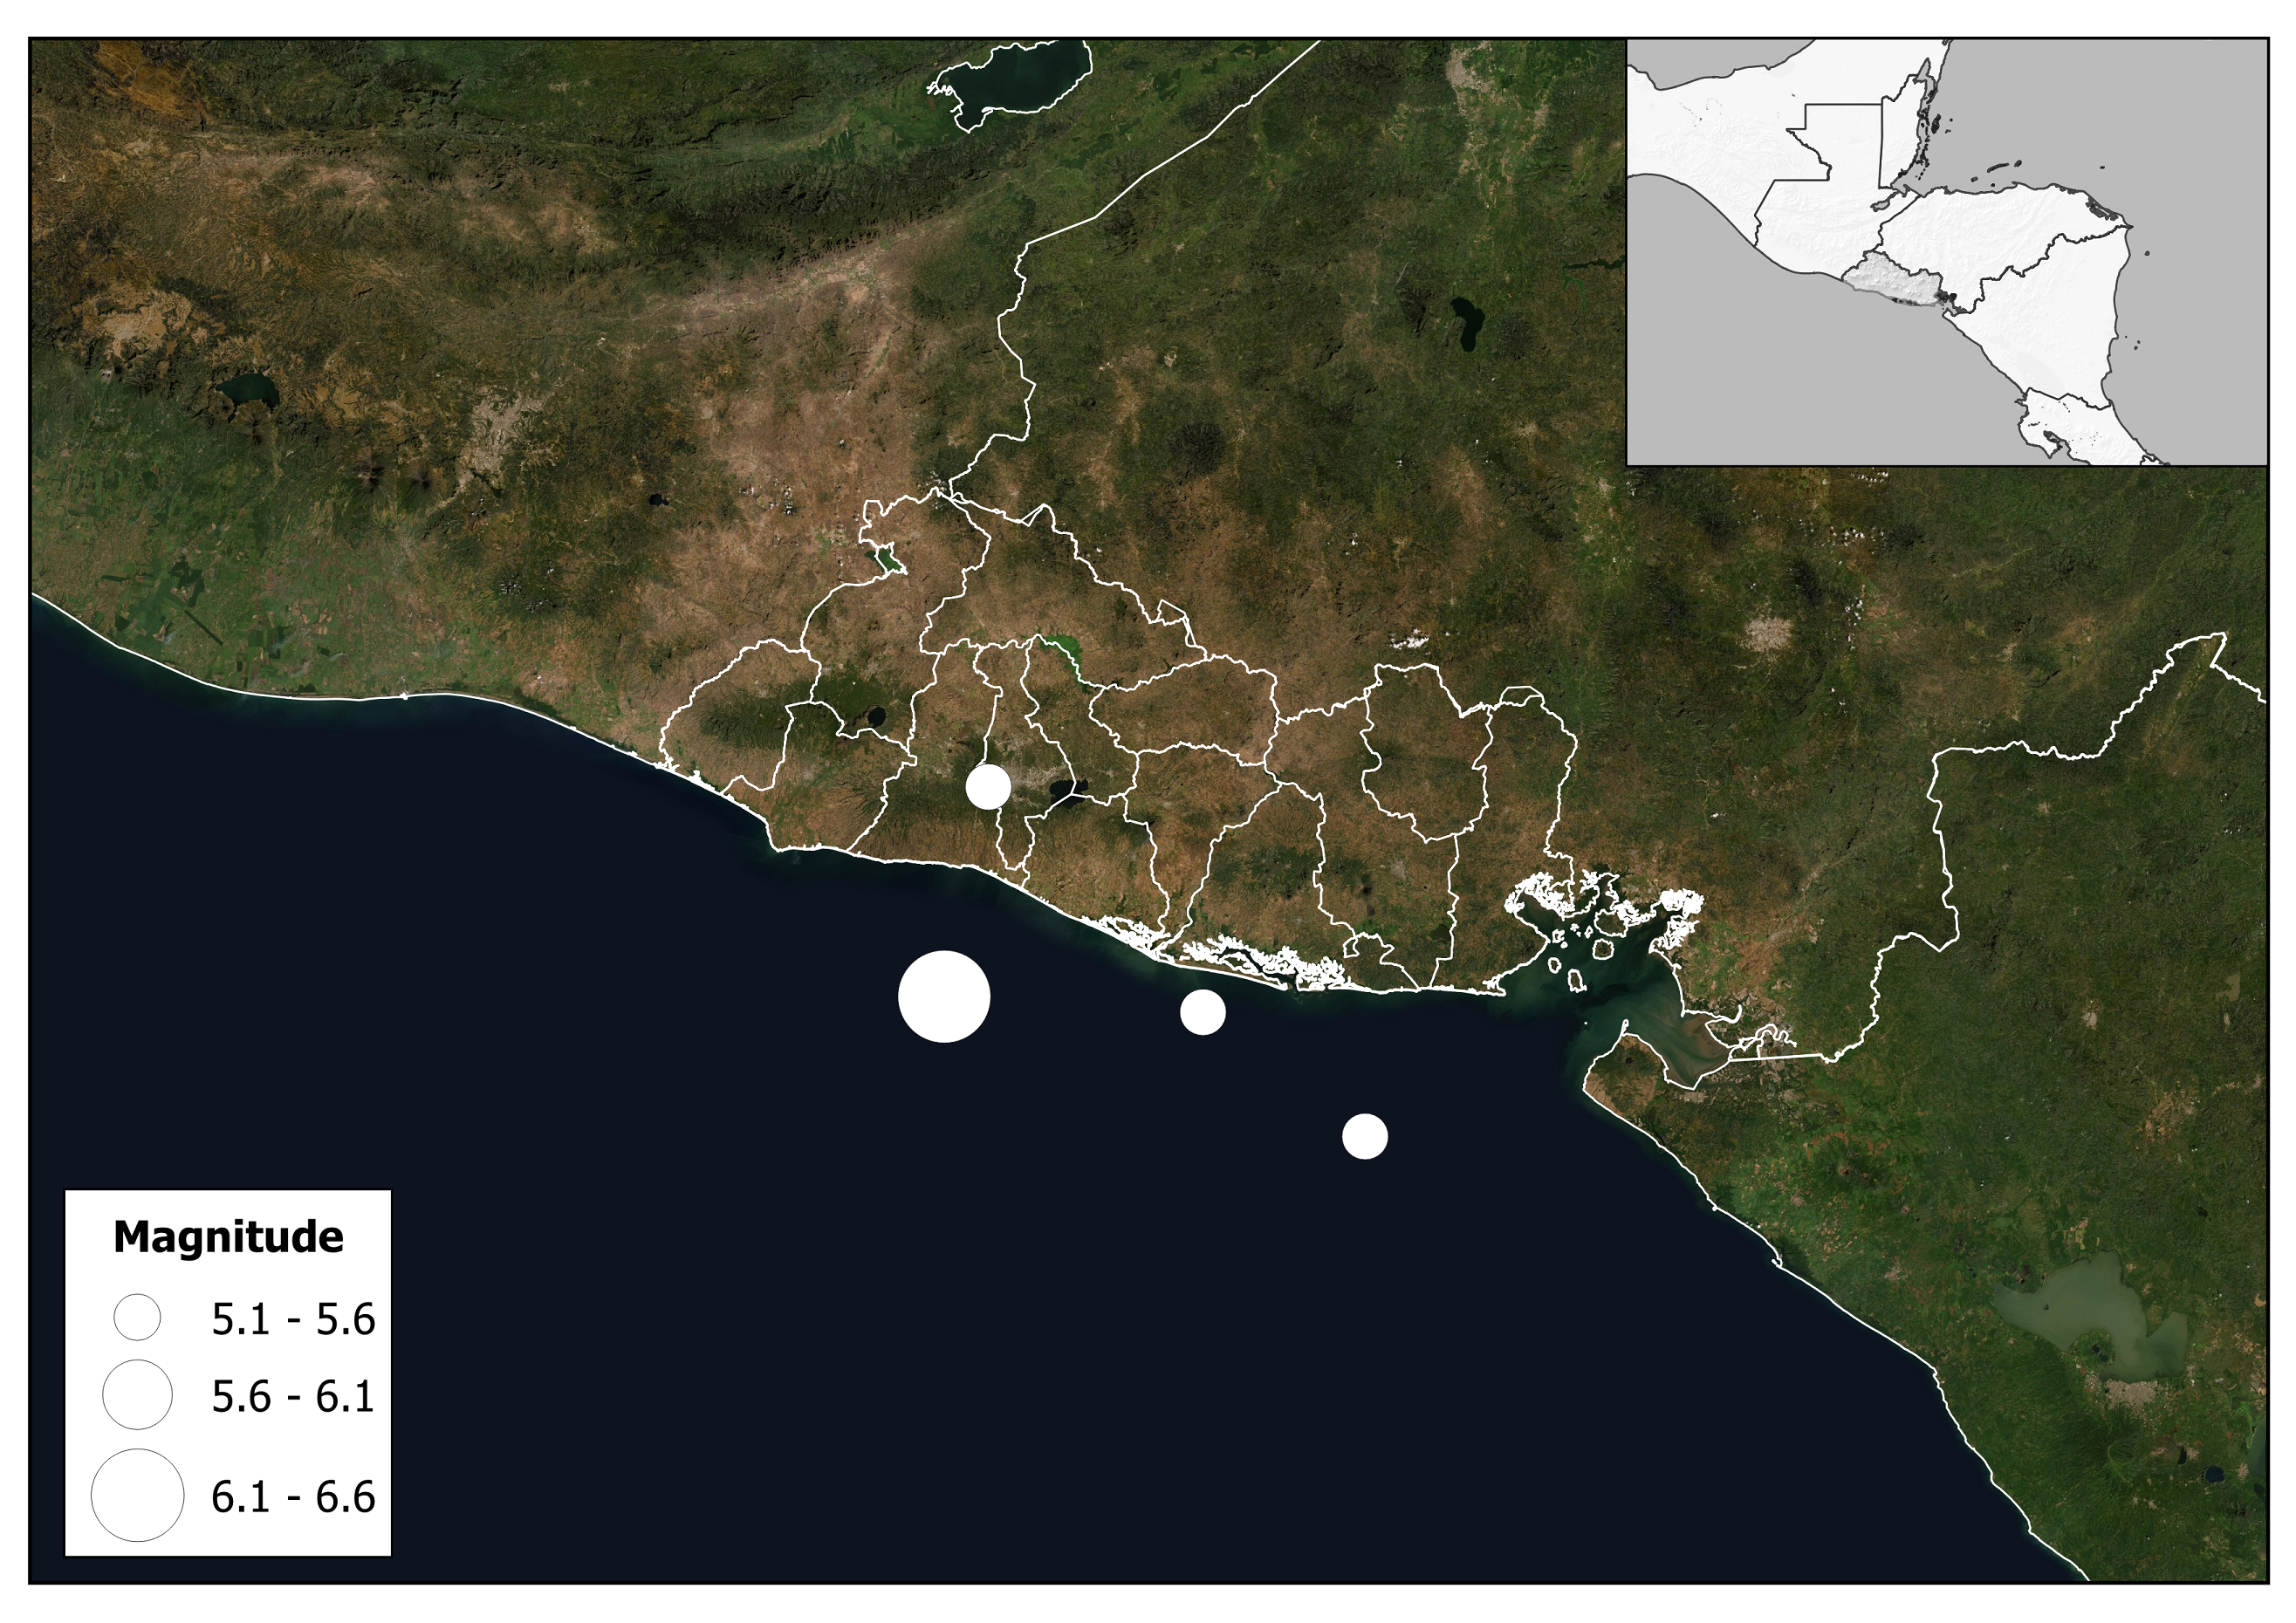

Initially, it's neccesary to import the packages that's will be neccesary to run the code.

In [3]:
#This set of packages will be used to read an txt file located in Google Drive
import pandas as pd
import numpy as np
import requests
from io import StringIO

from tqdm import tqdm

#obspy will be use to get te seismic data of salvadoran seismic network
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.trigger import ar_pick, classic_sta_lta, plot_trigger

#pykrige is used to build a linear interpolation
from pykrige.ok import OrdinaryKriging

import matplotlib.pyplot as plt

#shapefile is used as a method to remove the data outside El Salvador's shape.
import shapefile
from shapely.geometry import shape
from shapely.geometry import Point

At the beginning, it's necessary to know the information of the seismic stations. This is done reading a text file that is stored in google drive. 
The file contains the name of the station, coordinates and elevation. That information was obtain using Iris Station Map: https://ds.iris.edu/gmap/

In [4]:
orig_url='https://drive.google.com/file/d/1tJdQr80mClR3FOAxBCDLysq1wi41VXVq/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
station_sv = pd.read_csv(csv_raw, sep = '|')

a, b = station_sv.shape
name_station = station_sv[' Station ']

The information of every event (shown in the map above) are used. 
The array events store date and hour of the event, this format will be used to obtain seismic record with osbpy.
Also the coordinates of events are store to show the location in a map.

In [5]:
events = ['2018-04-02T23:23:14','2019-05-30T09:03:28', '2020-08-12T03:25:11']
magnitude = ['6.0','6.8','5.3']
dt = 20
coorX_eve = [-88.883, -89.37,-88.264]
coorY_eve = [12.914, 13.15, 12.7917]

The next line code is important. With the value of the variable event is possible to change the event we are studying.

In [12]:
event = 0

In this code, I'm using the ar_pic funtion to get the arrival of P wave and S wave in every record of the stations.
It was necessary to use try-except because some stations don't have record in some events.

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

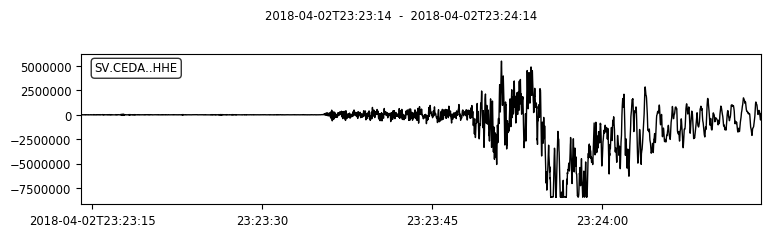

  8%|██████▉                                                                            | 1/12 [00:01<00:20,  1.82s/it]

P phase in  23 minutes and  35 seconds
S phase in  23 minutes and  50 seconds


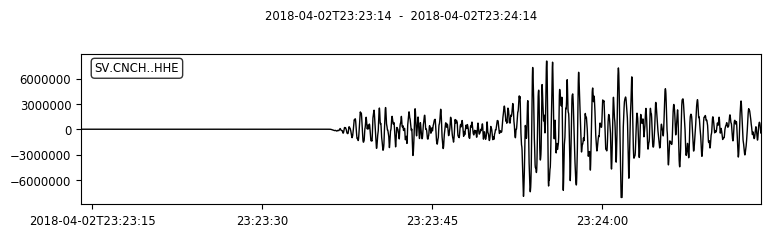

 17%|█████████████▊                                                                     | 2/12 [00:03<00:17,  1.74s/it]

P phase in  23 minutes and  36 seconds
S phase in  23 minutes and  14 seconds


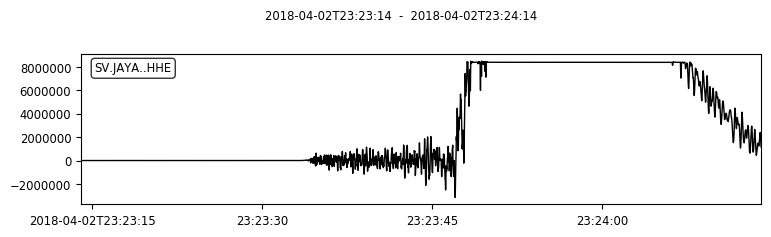

 25%|████████████████████▊                                                              | 3/12 [00:04<00:15,  1.68s/it]

P phase in  23 minutes and  43 seconds
S phase in  23 minutes and  49 seconds


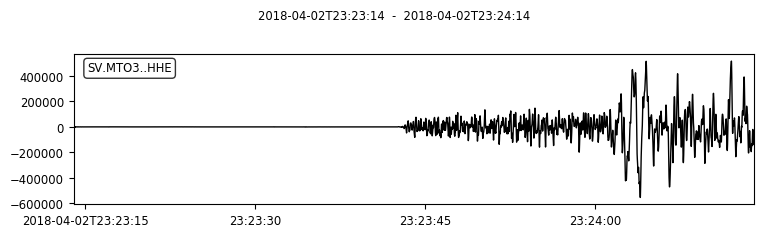

 33%|███████████████████████████▋                                                       | 4/12 [00:06<00:12,  1.57s/it]

P phase in  23 minutes and  43 seconds
S phase in  24 minutes and  6 seconds


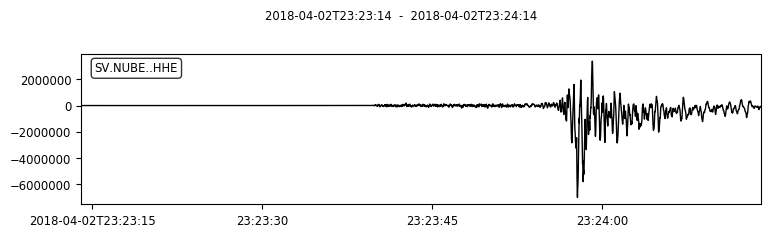

 42%|██████████████████████████████████▌                                                | 5/12 [00:07<00:10,  1.55s/it]

P phase in  23 minutes and  39 seconds
S phase in  23 minutes and  14 seconds


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:08<00:07,  1.27s/it]

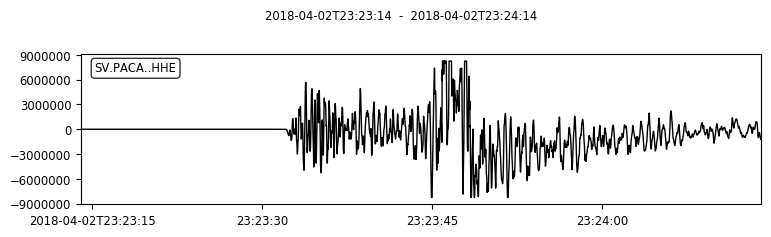

 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:09<00:06,  1.37s/it]

P phase in  23 minutes and  32 seconds
S phase in  23 minutes and  14 seconds


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:12<00:01,  1.07it/s]

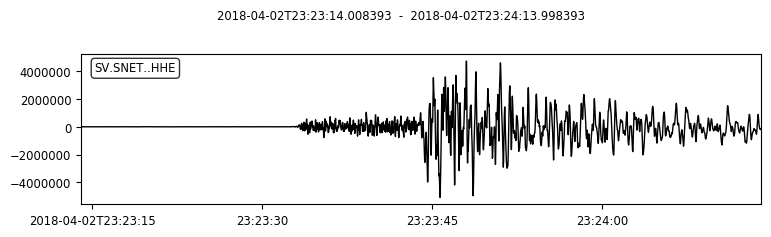

 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:13<00:01,  1.09s/it]

P phase in  23 minutes and  33 seconds
S phase in  23 minutes and  14 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.19s/it]


In [13]:
time_p = [] #array will store time of P wave
time_s = [] #array will store time of S wave
station = []

client = Client('IRIS')

for i in tqdm(name_station):
    starttime = UTCDateTime(events[event])
    try:
        ESA = client.get_waveforms("SV", i, "", "HH*", starttime, starttime + 60)
        trace1 = ESA[0]
        trace2 = ESA[1]
        trace3 = ESA[2]
        df = trace1.stats.sampling_rate
        p_pick, s_pick = ar_pick(trace1.data, trace2.data, trace3.data, df,
                             1.0, 30.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
        if p_pick > 0:
            time_p.append(p_pick)
            time_s.append(s_pick)
            station.append(i)
            trace1.plot()
            P = starttime + p_pick
            S = starttime + s_pick
            print('P phase in ', P.minute, 'minutes and ', P.second, 'seconds')
            print('S phase in ', S.minute, 'minutes and ', S.second, 'seconds')
        
    except:
        pass


Some stations dont have records, so it is necessary to use the stations that have records

In [14]:
coord_staX = []
coord_staY = []

for i in range(a):
    for j in station:
        if j == station_sv.iloc[i,1]:
            coord_staX.append(station_sv.iloc[i,3])
            coord_staY.append(station_sv.iloc[i,2])
            break

Once the P arrival is know, we'll use the package pykrige to build a linear interpolation.
The linear interpolation and the variogram parameters were choosen to delete some bad picking done by the ar_pick funtion.

In [15]:
xia = np.linspace(-90.1317, -87.677,200)
yia = np.linspace(13.15, 14.44,200)

OK = OrdinaryKriging(coord_staX, coord_staY, time_p, variogram_model='linear', variogram_parameters = {'slope' :5.0, 'nugget': 0.1}, verbose=True, enable_plotting=False,nlags=20)
z1, ss1 = OK.execute('grid', xia, yia)
xintrp, yintrp = np.meshgrid(xia, yia)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 5.0
Nugget: 0.1 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In order to obtain data inside country. We'll cut our data using a shapefile.

In [16]:
sf = shapefile.Reader(r"ElSalvador.shp")

feature = sf.shapeRecords()[0]
first = feature.shape.__geo_interface__  
shp_geom = shape(first)

for i in range(len(xintrp)):
    for j in range(len(yintrp)):
        temp = Point(xintrp[i,j],yintrp[i,j])
        proof = shp_geom.contains(temp)
        if proof == False:
                z1[i,j] = float('nan')

Finally, we plot the results.

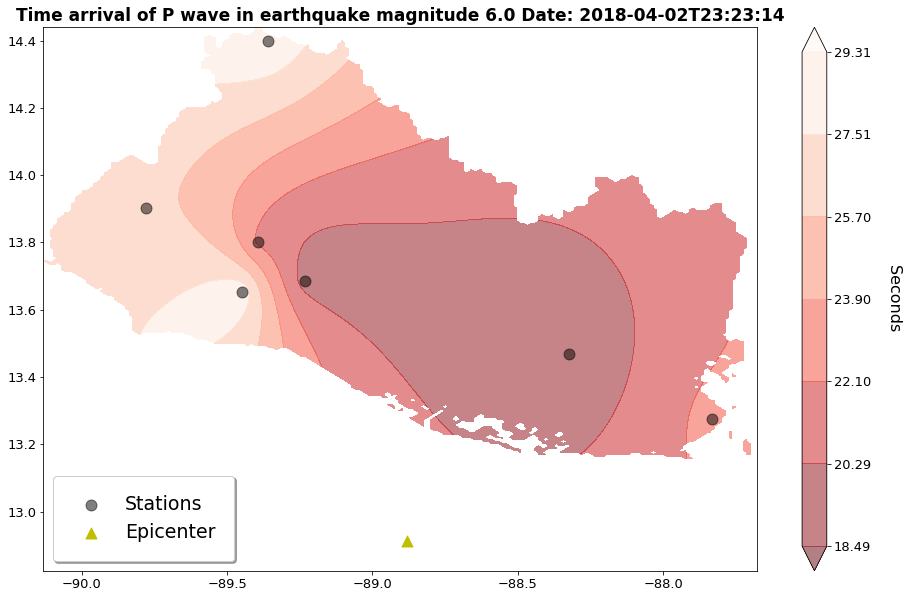

In [17]:
fig, ax = plt.subplots(figsize=(16,10))       

color_B = np.linspace(min(time_p),max(time_p),7)
cs=ax.contourf(xintrp, yintrp, z1, color_B ,extend='both',cmap='Reds_r', alpha = 0.5) #plot the data on the map.
cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=13) 
ax.tick_params(labelsize=13)
cbar.set_label('Seconds', rotation=270, labelpad=30, size = 16)


#ploteando estaciones
plt.title('Time arrival of P wave in earthquake magnitude ' + magnitude[event] + ' Date: ' + events[event], fontsize=17, weight = 'bold')
plt.scatter(coord_staX, coord_staY, marker='o',color='k', alpha = 0.5, label = 'Stations', s =120)
plt.scatter(coorX_eve[event], coorY_eve[event], marker='^',color='y', label = 'Epicenter', s =120)
ax.legend(loc='lower left', frameon=True, shadow=True, borderpad=1, fontsize=19)
plt.show()

If we apply the code to the other events, we obtain the next maps

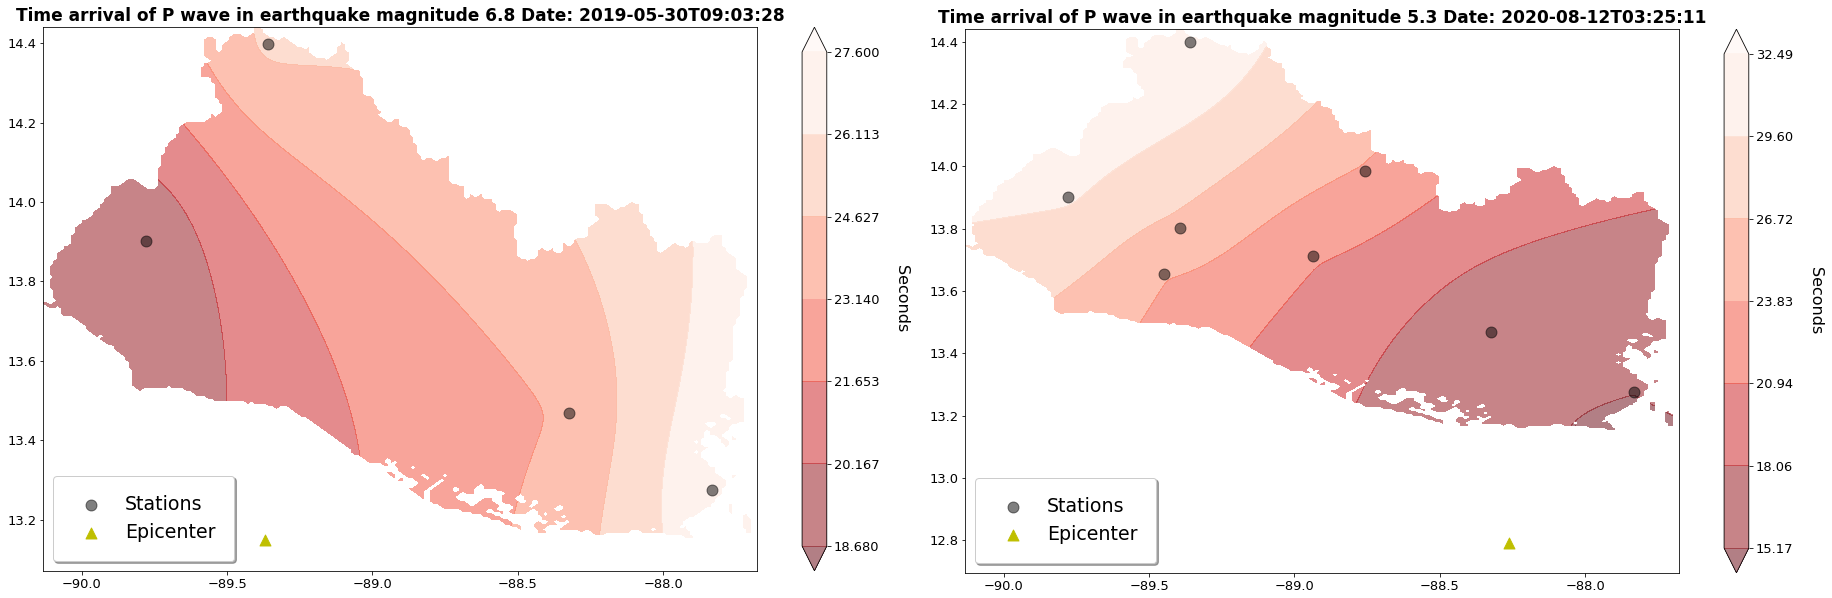

<h3> Conclusion </h3>
It can be really useful know the performance of automatic phase picking algorithm in countries like El Salvador, where the seismicity can be cause for the subducion zone and local faults. The picking algoritms can provide quick information about subduction earthquakes, which can cause tsunamis.
In spite of the magnitud of the local seismic (5.3 M), we observed the algoritm has troubles in the picking of the phases, this can be cause by the time between P phanse and S phase. 